## Kaggle Diabetic Retinopathy Classification

### Train labels

 Loading the dataset

In [17]:
from sklearn.model_selection import train_test_split
from shutil import copy

import matplotlib.pyplot as plt
import pandas as pd
import progressbar
import cv2
import os

In [18]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

In [19]:
DS_BASE_PATH = './Data'
DB_PATH = './DB'
reset_path(DB_PATH)

IMG_PATH = os.path.sep.join([DS_BASE_PATH, 'resized_train'])
csv_path = os.path.sep.join([DS_BASE_PATH,'trainLabels.csv'])

orig_ds = pd.read_csv(csv_path)
orig_ds

/bin/bash: /home/newton/anaconda3/envs/cujaface/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


level
0    25810
1     2443
2     5292
3      873
4      708
Name: image, dtype: int64

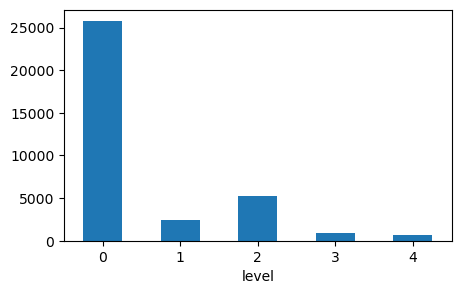

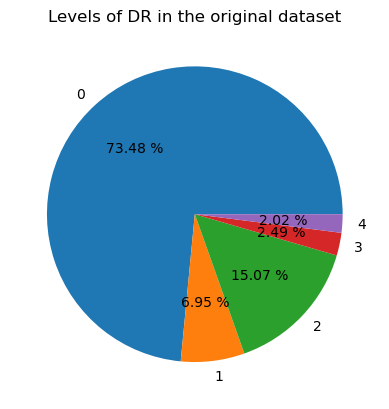

In [20]:
display(orig_ds.groupby('level')['image'].count())

dfp = orig_ds.pivot_table(
    index='level',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
plt.savefig(img_path)
plt.show()

level
0    700
1    700
2    700
3    700
4    700
Name: image, dtype: int64

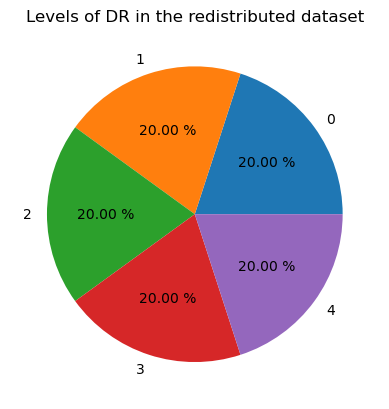

level
0    25110
1     1743
2     4592
3      173
4        8
Name: image, dtype: int64

In [21]:
dataset = orig_ds.groupby(['level']).sample(700)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

rest_df = orig_ds.loc[~orig_ds['image'].isin(dataset['image'])].dropna()

display(rest_df.groupby('level')['image'].count())

In [22]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.7,
    test_size=0.3,
    random_state=42
)

In [23]:
train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

In [24]:
remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

In [25]:
x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

In [26]:
val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

In [27]:
test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

In [28]:
display(train_df.groupby(['level'])['image'].count())
# plt.pie([train_df.loc[train_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
# plt.title("Levels of DR in the train_df")
# img_path = os.path.sep.join([DB_PATH, 'train_dist.png'])
# plt.savefig(img_path)
# plt.show()
train_df.head()

level
0    462
1    495
2    494
3    512
4    487
Name: image, dtype: int64

,image,level
17618,22160_left,3
26502,33561_left,0
14180,17805_left,1
7599,9586_right,2
13810,17331_left,2


In [29]:
display(val_df.groupby(['level'])['image'].count())
# plt.pie([val_df.loc[val_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
# plt.title("Levels of DR in the val_df")
# img_path = os.path.sep.join([DB_PATH, 'val_dist.png'])
# plt.savefig(img_path)
# plt.show()
val_df.head()

level
0    129
1     96
2    111
3     94
4     95
Name: image, dtype: int64

,image,level
69,70_right,0
29771,37647_right,1
26461,33493_right,4
30718,38833_left,1
17171,21558_right,3


In [30]:
display(test_df.groupby(['level'])['image'].count())
# plt.pie([test_df.loc[test_df['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
# plt.title("Levels of DR in the test_df")
# img_path = os.path.sep.join([DB_PATH, 'test_dist.png'])
# plt.savefig(img_path)
# plt.show()
test_df.head()

level
0    109
1    109
2     95
3     94
4    118
Name: image, dtype: int64

,image,level
35050,44253_left,0
34996,44200_left,3
34598,43732_left,2
15005,18798_right,2
8100,10156_left,2


In [33]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # # # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

def create_path(base_dir:str, dir_name:str):
    directory = os.path.sep.join([base_dir, dir_name])
    """
    Creates a new directory if it doesn't exist already

    - dir_name: path to directory
    """
    if not os.path.exists(directory):
        os.mkdir(directory)
    else:
        print(f'[INFO] {directory} already exists')
    
    return directory

def display_df_dist(df: pd.DataFrame, df_name:str):
    dfp = df.pivot_table(
        index='level',
        aggfunc='size'
    )
    dfp.plot(
        kind='bar',
        figsize=(5,3),
        rot=0
    )
    plt.title(f"Levels of DR in the {df_name} dataset")
    plt.savefig(os.path.sep.join(['DB', f'{df_name}.png']))
    plt.show()
    df.head()

def organize_set_imgs(df: pd.DataFrame, set_path:str):

    # images divided by class dir
    class_directories = {str(k):list(df['image'].loc[df['level'] == k]) for k in range(classes)}
    # display(class_directories)

    for k,imgs in class_directories.items():
        class_dir = create_path(set_path, k)

        widgets = [
            f'Building {set_path.split(os.path.sep)[-1]}/{k}:',
            ' ',
            progressbar.Percentage(),
            ' ',
            progressbar.Bar(),
            ' ',
            progressbar.Counter()
        ]

        pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(imgs))
        
        pbar.start()

        for i, img in enumerate(imgs):
            im_origin = os.path.sep.join([IMG_PATH, f'{img}.jpeg'])
            copy(im_origin, class_dir)
            im_path = os.path.join(class_dir,f'{img}.jpeg')
            clahe_image(im_path)

            pbar.update(i)
        
    pbar.finish()


[INFO] ./DB/Train already exists


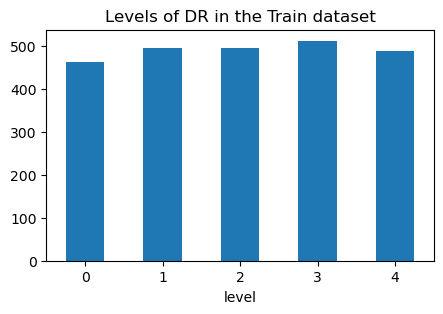

[INFO] ./DB/Train/0 already exists


Building Train/4: 100% |##################################################| 487


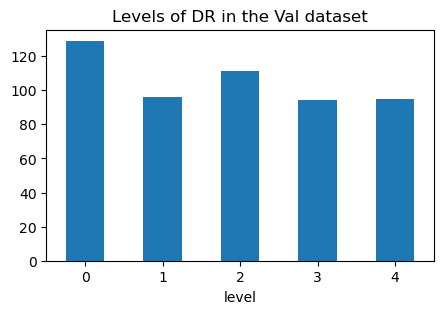

Building Val/4: 100% |#####################################################| 95


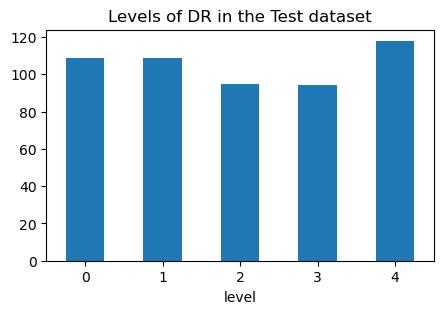

Building Test/4: 100% |###################################################| 118


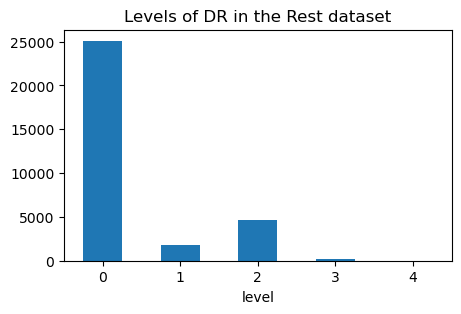

Building Rest/4: 100% |#####################################################| 8


In [34]:
data = [
    (train_df, 'Train'),
    (val_df, 'Val'),
    (test_df, 'Test'),
    (rest_df, 'Rest'),
]

for df, subset in data:
    ds_path = create_path(DB_PATH, subset)
    display_df_dist(df,  subset)
    organize_set_imgs(df, ds_path)